# Predicting fat content in the cheese dataset

## Foreword
This document is to serve as the solution example to the project for the **Introduction to Machine Learning course**. This document will demonstrate what a typical analysis of the cheese dataset using machine learning methods could look like.

# Introduction

## Question(s) of interest
In this analysis, I will be predicting the `FatLevel` using machine learning methods. I am interested to see **"Which cheese types on average contains higher fat levels and how well can we predict this by learning from the data?"**. Since I am not a cheese enthusiast or a connoisseur, I have little to no expectations. As such, it will be interesting to see which cheeses have the highest fat level and how well we can predict it. It will also be interesting to see which features contribute to predicting `FatLevel`. I will be setting `higher fat` level as the positive class and `lower fat` level as the negative class. Since the target contains only two classes, classification methods will be the most relevant for this problem.

## Dataset description
This dataset is the [Canadian Cheese Directory dataset](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b) from Agriculture and Agri-Food Canada.

# Exploratory Data Analysis

Before doing anything exciting, let's first import all the necessary libraries and do some exploratory data analysis.

In [42]:
# import the required libraries
import pandas as pd
import numpy as np
import altair as alt
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import make_scorer,  f1_score
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR

import scipy

First, let's read in the data and split them into our train and test sets before we do any exploratory data visualization. It's important to do this first, else we will be violating the golden rule. 

In [2]:
# Read in the data
cheese_df = pd.read_csv('data/cheese_data.csv', index_col=0)

In [3]:
# Split the dataset into train and test with a random state of 1994
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=1994)
train_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
CheeseId,,,,,,,,,,,,
2141,BC,Artisan,40.0,NaN,NaN,0,Semi-soft Cheese,Cow,Pasteurized,No Rind,Aged Farmhouse,higher fat
1026,ON,Industrial,34.0,NaN,NaN,0,Firm Cheese,Cow,Pasteurized,NaN,Romano (Ivanhoe),lower fat
1864,ON,Industrial,55.0,NaN,NaN,0,Soft Cheese,Goat,Pasteurized,Bloomy Rind,Santa Lucia Goat Cheese Brie,higher fat
1402,QC,Industrial,39.0,Buttery and creamy lactic flavor,Daily fresh,0,Firm Cheese,Cow,Pasteurized,No Rind,Cheddar doux Riviera,higher fat
1900,QC,Farmstead,60.0,Mild and floral taste becoming sharper with age,NaN,0,Soft Cheese,Goat,Thermised,Bloomy Rind,Bûchette et Pyramide Mes Petits Caprices,lower fat


In [4]:
# Let's get some information about the training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 2141 to 1462
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  833 non-null    object 
 1   ManufacturingTypeEn   833 non-null    object 
 2   MoisturePercent       822 non-null    float64
 3   FlavourEn             636 non-null    object 
 4   CharacteristicsEn     506 non-null    object 
 5   Organic               833 non-null    int64  
 6   CategoryTypeEn        818 non-null    object 
 7   MilkTypeEn            833 non-null    object 
 8   MilkTreatmentTypeEn   781 non-null    object 
 9   RindTypeEn            566 non-null    object 
 10  CheeseName            833 non-null    object 
 11  FatLevel              833 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 84.6+ KB


There appears to be a total of `12` columns and `833` rows in the training dataset. Two of these columns are numeric (`MoisturePercent` and `Organic`). The remaining `10` columns are non-numeric. There are a few columns (`FlavourEN`,`CharacteristicsEn`, `MilkTreatmentTypeEn`, `RindTypeEn`) with missing(null) values. In order to use these columns for prediction, imputation will need to be done. Depending on the column type, there are a few imputation methods available for use.

In [5]:
# Let's take a closer look at the numeric columns more closely
train_df.describe()

,MoisturePercent,Organic
count,822.000000,833.000000
mean,46.931630,0.096038
std,9.738151,0.294821
min,12.000000,0.000000
25%,40.000000,0.000000
50%,45.000000,0.000000
75%,52.000000,0.000000
max,92.000000,1.000000


The `MoisturePercent` column appears to be missing `11` rows and the `Organic` column is not missing any values. The `MoisturePercent` values range between `12` and `92` meaning that there is no cheese with `100%` moisture and no cheese with `0%` moisture. 

It seems that the distribution of the `Organic` column is bimodal with values taking either `0` or `1`. This implies that this column is binary as well and is represented using numerical values. In contrast, the `MoisturePercent` column is more normally distributed. Let's see if this is the case using `histograms`.

In [6]:
# The organic column
organic_plt = alt.Chart(train_df,width=500,height=300).mark_bar().encode(
    x=alt.X('Organic'),
    y='count()'
).properties(
    title='Histogram of Organic column'
)

organic_plt

alt.Chart(...)

In [7]:
# The MoisturePercent column
moisture_plot = alt.Chart(cheese_df,width=500,height=300).mark_bar().encode(
    x=alt.X('MoisturePercent'),
    y='count()'
).properties(
    title='Histogram of MoisturePercent'
)


moisture_plot

alt.Chart(...)

As expected, the `Organic` column is bimodal and the `MoisturePercent` column is normally distributed.

Before learning from the data, I would like to see if they are balanced. This means that for the target column (`FatLevel`), we have an equal number of data points for all the possible classes. To do this, I will generate a histogram of the classes and their counts.

In [8]:
fatlevel_plot = alt.Chart(cheese_df,width=500,height=300).mark_bar().encode(
    x=alt.X('FatLevel'),
    y='count()'
).properties(
    title='Histogram of FatLevel'
)
fatlevel_plot

alt.Chart(...)

# Methods and Results

Since I am interested in predicting `FatLevel` which is a categorical column, I will need to use a classification method. I am also interested in knowing which features are most helpful in predicting `FatLevel` so I will need to use a model where I can interpret the model parameters. The perfect candidate for this is the `Logistic Regression` model. Let's get started.

I will split the features into various types. The `CheeseName` and `FlavourEn` most likely have no impact on the fat level so those columns will be dropped. I will also be dropping the `RindTypeEn` column.

In [9]:
numeric_features = ['MoisturePercent']
categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_features = ['Organic']
drop_features = ['CheeseName', 'FlavourEn', 'RindTypeEn', 'FatLevel']
target_column = 'FatLevel'

Next I will preprocess the features using the appropriate column transformers. For the numeric features, I will be using the `SimpleImputer(strategy='median')` for imputation and the `StandardScaler()` for data scaling. For the categorical features, I will be using the `SimpleImputer(strategy='constant')` for imputation and one hot encoding will be done using `OneHotEncoder(sparse=False, handle_unknown='ignore')`. Finally, for the binary features, I will using `SimpleImputer(strategy="most_frequent")` for imputation and one hot encoding will be done using `OneHotEncoder(drop="if_binary", dtype=int)`.

In [10]:
# Get the training and testing target values
X_train = train_df.drop(columns=drop_features)
y_train = train_df[target_column]

X_test = test_df.drop(columns=drop_features)
y_test = test_df[target_column]

y_train.head()

CheeseId
2141    higher fat
1026     lower fat
1864    higher fat
1402    higher fat
1900     lower fat
Name: FatLevel, dtype: object

## The DummyClassifier

Before constructing more complex classifiers, it is always a good idea to have an idea of a baseline. Having a baseline enables us to gauge the performance of more complex classifiers. As a baseline, I will be using a `DummyClassifier` with the `stratified` strategy.

Since we have a class imbalance, we will have to make a custom scorer to measure f1 score in `cross_validate()` which specifies the positive class as "higher fat". We did not explicitly explain this in the notes but now if you come across this issue, you will be able to refer to the below code as an example. 

In [11]:
f1_scorer = make_scorer(f1_score, pos_label="higher fat")

Next, we transform our cross-validation scores from our `DummyClassifier` into a dataframe so we can see how well we are predicting with a baseline model. 

In [12]:
dummy_scores = pd.DataFrame(cross_validate(DummyClassifier(strategy="stratified"), X_train, y_train, cv=5, 
                                           return_train_score=True,
                                           scoring={"acc":"accuracy", "f1": f1_scorer}))
dummy_scores

,fit_time,score_time,test_acc,train_acc,test_f1,train_f1
0,0.001619,0.001892,0.520958,0.513514,0.259259,0.330579
1,0.001904,0.003106,0.592814,0.537538,0.413793,0.368852
2,0.001652,0.001859,0.473054,0.516517,0.241379,0.342857
3,0.001460,0.002289,0.542169,0.557721,0.296296,0.357298
4,0.001033,0.001867,0.518072,0.557721,0.365079,0.371002


Let's now find the average scores across all runs. 

In [13]:
dummy_scores.mean()

fit_time      0.001534
score_time    0.002203
test_acc      0.529413
train_acc     0.536602
test_f1       0.315161
train_f1      0.354118
dtype: float64

As expected, the dummy classifier does quite poorly with scores on par with guessing.

## Columns Preprocessing

I will next train two well known classifiers. A `Logistic Regression` model and a `Support Vector Classifier` model. However, before I do that, I need to preprocess the columns and handle the null value cases.

In [14]:
# The numeric transformer
numeric_transformer = make_pipeline(SimpleImputer(strategy='median'),
                                    StandardScaler()
)
# The categorical transformer
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant'),
                                        OneHotEncoder(sparse=False, handle_unknown='ignore')
)
# The binary transformer
binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                   OneHotEncoder(drop="if_binary", dtype=int)
)

In [187]:
# Define a preprocessor for the columns
preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        (binary_transformer, binary_features)
)

## Logistic Regression

I will fit a logistic regression model and compute its performance. Since this dataset is unbalanced, the `class_weight` argument will be set to `balanced` with `maxiter=10000`.

In [64]:
# Create the pipeline containing the ColumnTransformer and the Logistic Regression model
pipeline_lr = make_pipeline(preprocessor, 
                            LogisticRegression(class_weight='balanced', max_iter=10000))

In [65]:
# Run the pipeline with 5-fold CV
scores_lr = pd.DataFrame(cross_validate(pipeline_lr, X_train, y_train, cv=5, 
                              return_train_score=True,
                              scoring={"acc":"accuracy", "f1": f1_scorer}))
scores_lr

,fit_time,score_time,test_acc,train_acc,test_f1,train_f1
0,0.037055,0.013267,0.778443,0.767267,0.725926,0.701349
1,0.038291,0.010809,0.724551,0.786787,0.676056,0.721569
2,0.029744,0.008160,0.706587,0.777778,0.601626,0.718631
3,0.025548,0.008158,0.777108,0.773613,0.699187,0.709056
4,0.026542,0.010183,0.813253,0.769115,0.755906,0.703846


In [66]:
# Compute the mean scores
scores_lr.mean()

fit_time      0.031436
score_time    0.010115
test_acc      0.759988
train_acc     0.774912
test_f1       0.691740
train_f1      0.710890
dtype: float64

Compared to the dummy classifier, the `LogisticRegression` classifier does much better as can be seen by the significant improvement in the scores.

## Support Vector Classifier

The next classifier that will be used to predict the `FatLevel` in the cheese data, will be the SVM with an RBF kernel. I will run this model with `balanced` class weights.

In [35]:
# Create the pipeline
pipeline_svc = make_pipeline(preprocessor,
                             SVC(class_weight='balanced', kernel='rbf'))

In [36]:
# Run the pipeline with 5-fold CV
scores_svc = pd.DataFrame(cross_validate(pipeline_svc, X_train, y_train, cv=5, 
                                         return_train_score=True,
                                         scoring={"acc":"accuracy", "f1": f1_scorer}))
scores_svc

,fit_time,score_time,test_acc,train_acc,test_f1,train_f1
0,0.040026,0.015593,0.790419,0.816817,0.755245,0.777372
1,0.034209,0.011332,0.766467,0.828829,0.723404,0.779923
2,0.026218,0.011184,0.730539,0.830330,0.634146,0.783109
3,0.029513,0.011220,0.753012,0.838081,0.649573,0.788235
4,0.029799,0.010826,0.801205,0.814093,0.748092,0.769517


In [37]:
# Compute the mean scores
scores_svc.mean()

fit_time      0.031953
score_time    0.012031
test_acc      0.768328
train_acc     0.825630
test_f1       0.702092
train_f1      0.779631
dtype: float64

This model fairs much better than the dummy classifier and marginally better than the Logistic Regression Classifier. However, the increase in performance does not sway me enough to abandon the interpretability of the features that comes along with Logistic Regression. Remember that in Machine learning, accuracy is not always the most valuable aspect of a model. 

## Hyperparameter Tuning

Next, I will perform hyperparameter tuning for both the logistic regression and the support vector classifier models. We've only asked you to do one, however, we are providing you with both here as an example.

For the logistic regression model, I will be tuning the value for `C` and the `penalty` function (No need to understand what the penalty hyperparameter is doing. It's simply a hyperparameter that I am optimizing). For the support vector classifier model, I will be tuning `gamma` and `C` (a different `C` than Logistic Regression). I will be using the `RandomizedSearchCV` due to its speed and comparable scores. 

### Optimize Logistic Regression

In [202]:
# First define a parameter grid to optimize over
param_grid_lr = {
    "logisticregression__C": scipy.stats.loguniform(1e-3, 1e3),
    'logisticregression__penalty' : ['l1', 'l2']
}
# Perform the search
random_search_lr = RandomizedSearchCV(pipeline_lr, param_grid_lr,
                                      n_iter=50, verbose=1,
                                      n_jobs=-1, random_state=777,
                                      return_train_score=True,
                                      scoring=f1_scorer)

# Fit this to the training data
random_search_lr.fit(X_train,y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 235 out of 250 | elapsed:    5.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.3s finished


Get the optimal parameters:

In [82]:
optimal_parameters_lr = random_search_lr.best_params_
optimal_score_lr = random_search_lr.best_score_

print("Best Parameters:", optimal_parameters_lr)
print("Best_Score:", optimal_score_lr)

Best Parameters: {'logisticregression__C': 0.5743307240441112, 'logisticregression__penalty': 'l2'}
Best_Score 0.6950368388715911


The best parameter for `C` and `penalty` are $0.56$ and `l2` which gives a validation f1 score of $0.70$.

Next, I'll score the model on the training and the test set:

In [107]:
# Score the best model on the training and test set
train_score_lr = random_search_lr.score(X_train, y_train)
test_score_lr = random_search_lr.score(X_test, y_test)

print("Train f1 score:", round(train_score_lr,4))
print("Test f1 score:", round(test_score_lr,4))

Train f1 score: 0.7154
Test f1 score: 0.6853


### Optimize Support Vector Classifier

We will repeat the same hyperparameter optimizing technique but this time using the SVC model and the hyperparameters `C` and `gamma`. 

In [108]:
# Define a parameter grid to optimize over
param_grid_svc = {
    "svc__C": loguniform(1e-3, 1e3),
    'svc__gamma' : loguniform(1e-3, 1e3)
}
# Perform the search
random_search_svc = RandomizedSearchCV(pipeline_svc,param_grid_svc,
                                   n_iter=50, verbose=1,
                                   n_jobs=-1, random_state=777,
                                   return_train_score=True,
                                   scoring=f1_scorer)
# Fit this to the training data
random_search_svc.fit(X_train,y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.3s finished


Get the optimal parameters:

In [109]:
optimal_parameters_svc = random_search_svc.best_params_
optimal_score_svc = random_search_svc.best_score_

print("Best Parameters:", optimal_parameters_svc)
print("Best_Score:", optimal_score_svc)

Best Parameters: {'svc__C': 103.67175660466815, 'svc__gamma': 0.3515053496712001}
Best_Score: 0.7210864938277168


The best parameter for `C` and `gamma` are $103.67$ and `0.352` and gives a validation f1 score of $0.72$.  This is slightly better than the result obtained from the logistic regression model.

Let's score the model on the training and test set now: 

In [110]:
# Score the best model on the training and test set
train_score_svc = random_search_svc.score(X_train, y_train)
test_score_svc = random_search_svc.score(X_test, y_test)

print("Train f1 score:", round(train_score_svc,4))
print("Test f1 score:", round(test_score_svc,4))

Train f1 score: 0.8522
Test f1 score: 0.7027


## Model Comparisons

### Before hyperparameter tuning

In [111]:
model_dict = {'Dummy': dummy_scores.mean(),
    'LR': scores_lr.mean(),
    'SVC': scores_svc.mean()}
pd.DataFrame(data=model_dict)

,Dummy,LR,SVC
fit_time,0.001534,0.031436,0.031953
score_time,0.002203,0.010115,0.012031
test_acc,0.529413,0.759988,0.768328
train_acc,0.536602,0.774912,0.825630
test_f1,0.315161,0.691740,0.702092
train_f1,0.354118,0.710890,0.779631


### After hyperparameter tuning

In [112]:
scores_dict = {'LR': [test_score_lr, train_score_lr],
    'SVC': [test_score_svc, train_score_svc]}
pd.DataFrame(data=scores_dict, index = ['test f1 score', 'train f1 score'])

,LR,SVC
test f1 score,0.685315,0.702703
train f1 score,0.715397,0.852201


Both the logistic regression and the SVC models outperform the dummy classifier in all aspects. The SVC model has a marginally better testing accuracy than that of the logistic regression model. This implies that the SVC model is overall better at predicting `FatLevel` for this dataset. 

### Classification statistics

Let's take a look at the classification report and the confusion matrices for both models.

#### Logistic Regression

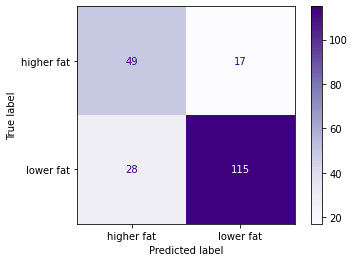

In [113]:
# Plot the confusion matrix
lr_cm_plot = plot_confusion_matrix(
    random_search_lr,
    X_test,
    y_test,
    cmap="Purples"
)
lr_cm_plot;

In [114]:
# Print the classification report for the test set
print(classification_report(y_test, random_search_lr.predict(X_test), 
                            digits=4))

              precision    recall  f1-score   support

  higher fat     0.6364    0.7424    0.6853        66
   lower fat     0.8712    0.8042    0.8364       143

    accuracy                         0.7847       209
   macro avg     0.7538    0.7733    0.7608       209
weighted avg     0.7970    0.7847    0.7887       209



Overall, the logistic regression model performs quite well. When predicting `higher fat` as our positive class,  we have a precision of $0.64$, a recall of $0.71$ and an f1 score of $0.67$. We are more specific when predicting `lower fat` and more sensitive when predicting `lower fat` as well since the precision and recall scores are higher if `lower fat` is labeled as the positive class (0.86 and 0.81 respectively). We also see a better `f1` score when predicting `lower fat`.

#### Support Vector Classification

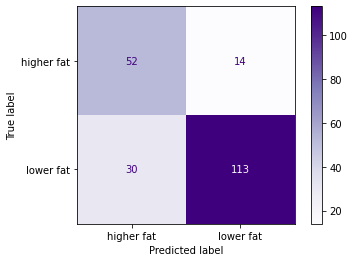

In [115]:
# plot the confusion matrix
svc_cm_plot = plot_confusion_matrix(
    random_search_svc,
    X_test,
    y_test,
    cmap="Purples"
)
svc_cm_plot;

In [116]:
# print the classification report for the test set
print(classification_report(y_test, random_search_svc.predict(X_test), 
                            digits=4))

              precision    recall  f1-score   support

  higher fat     0.6341    0.7879    0.7027        66
   lower fat     0.8898    0.7902    0.8370       143

    accuracy                         0.7895       209
   macro avg     0.7620    0.7890    0.7699       209
weighted avg     0.8090    0.7895    0.7946       209



Overall, the support vector classifier model performs quite well. When predicting `higher fat` as our positive class, we have a precision of $0.63$, a recall of $0.79$ and an f1 score of $0.70$. Again for our SVC model, we obtain higher recall and precision measurements when predicting `lower fat` as our positive class. We also see a better `f1` score.

## Model interpretation

Finally, since I am using a logistic regression model, I will take a look at the significance of the features used for prediction by looking at the coefficients from the model.

We need to see which class is the baseline for our regression model. We can do this by calling `.classes_`. 

In [203]:
random_search_lr.best_estimator_['logisticregression'].classes_

array(['higher fat', 'lower fat'], dtype=object)

This tells us that the default baseline is the `higher fat` category since it comes first. That means that positive coefficients will contribute to the prediction of `lower fat` chesses and negative coefficients contribute to the prediction of `higher fat` cheeses. 

Let's get all the columns that our transformed data. To to this we will first need to fit our ColumnTransformer:

In [288]:
preprocessor.fit(X_train); 

We can obtain the new categorical features from one-hot encoding with the code below and we transform it into a list. 

In [284]:
onehot_feat_names = preprocessor.named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names(categorical_features).tolist()

Next, we combine all the columns feature names together: 

In [285]:
all_feat_names = numeric_features + onehot_feat_names + binary_features

In [287]:
coefs = random_search_lr.best_estimator_['logisticregression'].coef_
coefs_df = pd.DataFrame(data = [all_feat_names,
                                coefs.flatten()]).T.rename(columns={0:'feature', 1:'coefficient'})
coefs_df.sort_values('coefficient', key=abs,ascending=False)

,feature,coefficient
0,MoisturePercent,1.91246
18,CategoryTypeEn_Soft Cheese,-1.03298
27,MilkTypeEn_Goat,0.944134
2,ManufacturerProvCode_BC,-0.88209
4,ManufacturerProvCode_NB,0.821948
3,ManufacturerProvCode_MB,0.804626
16,CategoryTypeEn_Hard Cheese,0.628278
20,CategoryTypeEn_missing_value,0.49884
29,MilkTreatmentTypeEn_Raw Milk,-0.49342
25,MilkTypeEn_Ewe and Cow,-0.445125


It appears that the `MoisturePercent` feature has the most significant impact on predicting `FatLevel` and the `ManufacturerProvCode_SK` has the least significant impact on predicting `FatLevel`. 

# Discussions

In this document, I was interested in classifying `FatLevel` from the cheese dataset using two well-known classification methods. Not all columns were relevant for doing this classification so a few of the columns were dropped. Columns that were relevant for classification had missing information so they had to be processed depending on their data types. Firstly, I used a dummy classifier that would allow me to create a baseline to which I could compare more complex models. As expected, this baseline performed poorly. Next, I fitted two models to the data. A `Logistic Regression` (LR) model and a `Support Vector Classifier` (SVC) model. 5-fold cross-validation was done to train the model and specific parameters were tuned using `RandomizedGridSearch`. After tuning, both models had similar performance when classifying `FatLevel` with the SVC model performing marginally better. Sensitivity and specificity analysis showed that both models performed better when classifying examples as `lower fat` vs `higher fat`. Overall, I am satisfied with the analysis and the performance of both models. In terms of improving the overall performance of models, a few ideas come to mind. A wider range of hyperparameters may have helped to improve the performance by searching a larger space. Next, the models could have been tuned using more hyperparameters. Finally, different classification models could have been employed and tuned as well. For example, decision trees and random forests could be used to predict `FatLevel`, however, I do not believe that doing this will significantly (> 10\%) increase our scores.

# References

- Material from UBC's [CPSC330](https://github.com/UBC-CS/cpsc330) course by Mike Gelbart.

- Data from [The Government of Canada's Open Government Portal](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b)
    * This cheese dataset was modified from the Canadian Cheese Directory database.


![](data/cheese_meme.jpg)

Image obtained from [here](https://www.dailymoss.com/10-funny-cheese-jokes-for-people-with-sense-of-humor-good-taste/?fbclid=IwAR0YzbdvkLG7oaUHFSHrhB64rhzVDs-KCasA5d0IoVIJkVrNJUz6Uemvo9U).